<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Solución Desafío 4 - Traductor Seq2Seq con PyTorch
## Modelo Encoder-Decoder LSTM para Traducción Inglés-Español

### Objetivos del Desafío

1. **Replicar el modelo en PyTorch** siguiendo la arquitectura del notebook de referencia
2. **Extender el entrenamiento** a más datos y tamaños de secuencias mayores
3. **Explorar el impacto** de la cantidad de neuronas en las capas recurrentes
4. **Mostrar 5 ejemplos** de traducciones generadas por el modelo

### Mejoras Implementadas

- Uso de **más muestras del dataset** (10,000 vs 6,000 original, configurable hasta 15k+)
- **Secuencias más largas** (20/22 vs 16/18) para capturar mejor contexto
- **Comparación de arquitecturas** con diferentes tamaños de LSTM (64, 128, 256)
- **Dataset optimizado** con one-hot encoding bajo demanda (ahorra ~21GB de RAM)
- **Early stopping** para evitar overfitting
- **Análisis detallado** de traducciones con métricas de calidad
- **Visualizaciones mejoradas** de resultados

### Requisitos de Memoria

- **Mínimo**: 4GB RAM (usar MAX_NUM_SENTENCES = 5000)
- **Recomendado**: 8GB+ RAM (usar MAX_NUM_SENTENCES = 10000)
- **Óptimo**: 16GB+ RAM (usar MAX_NUM_SENTENCES = 15000+)

## 1. Setup e Importaciones

In [1]:
# Instalar dependencias necesarias
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install torchinfo --quiet

In [2]:
import re
import os
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# Verificar disponibilidad de GPU
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(f"Dispositivo: {device}")
print(f"PyTorch version: {torch.__version__}")

Dispositivo: cpu
PyTorch version: 2.7.1+cpu


## 2. Descarga de Helpers y Embeddings

In [3]:
# Descargar torch_helpers si no existe
import platform

if not os.path.exists('torch_helpers.py'):
    print("Descargando torch_helpers.py...")
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget -O torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
else:
    print("torch_helpers.py ya existe")

torch_helpers.py ya existe


In [4]:
from torch_helpers import Tokenizer, pad_sequences

## 3. Descarga del Dataset

Utilizaremos el dataset de traducciones inglés-español de Anki.

In [5]:
import gdown

if not os.path.exists('spa-eng'):
    if not os.path.exists('spa-eng.zip'):
        print("Descargando dataset...")
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    print("Extrayendo dataset...")
    !unzip -q spa-eng.zip
else:
    print("Dataset ya descargado")

Dataset ya descargado


## 4. Carga y Preprocesamiento del Dataset

### MEJORA 1: Usar más datos

En el notebook original se usaban solo 6,000 muestras. Aquí usaremos configuraciones variables para experimentar.

In [6]:
# CONFIGURACIÓN: Ajustar según disponibilidad de RAM
# ⚠️ IMPORTANTE: Si tienes problemas de memoria, reduce MAX_NUM_SENTENCES
#
# Recomendaciones:
# - RAM < 8GB:  MAX_NUM_SENTENCES = 5000
# - RAM 8-16GB: MAX_NUM_SENTENCES = 10000
# - RAM > 16GB: MAX_NUM_SENTENCES = 15000+
#
MAX_NUM_SENTENCES = 10000  # Reducido de 15000 para mayor compatibilidad

# Cargar dataset
text_file = "./spa-eng/spa.txt"
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

print(f"Total de líneas disponibles: {len(lines):,}")
print(f"Usando: {MAX_NUM_SENTENCES:,} muestras")

# Mezclar dataset
np.random.seed(42)
np.random.shuffle(lines)

# Procesar líneas
input_sentences = []
output_sentences = []
output_sentences_inputs = []

for i, line in enumerate(lines[:MAX_NUM_SENTENCES]):
    if '\t' not in line:
        continue
    
    # Input: inglés, Output: español
    input_sentence, output = line.rstrip().split('\t')
    
    # Agregar tokens especiales
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output
    
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print(f"Muestras procesadas: {len(input_sentences):,}")
print(f"\nEjemplo:")
print(f"  Entrada (EN): {input_sentences[0]}")
print(f"  Salida (ES):  {output_sentences[0]}")
print(f"  Input Dec:    {output_sentences_inputs[0]}")

Total de líneas disponibles: 118,964
Usando: 10,000 muestras
Muestras procesadas: 10,000

Ejemplo:
  Entrada (EN): How boring!
  Salida (ES):  ¡Qué aburrimiento! <eos>
  Input Dec:    <sos> ¡Qué aburrimiento!


## 5. Tokenización y Preparación de Secuencias

### MEJORA 2: Secuencias más largas

In [7]:
# Tamaño máximo de vocabulario
MAX_VOCAB_SIZE = 8000

# Tokenizer para inglés (input)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print(f"Vocabulario inglés: {len(word2idx_inputs):,} palabras")

max_input_len_original = max(len(sen) for sen in input_integer_seq)
print(f"Longitud máxima (inglés): {max_input_len_original}")

Vocabulario inglés: 5,056 palabras
Longitud máxima (inglés): 36


In [8]:
# Tokenizer para español (output)
# Mantener <sos> y <eos> en el vocabulario
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, 
    filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print(f"Vocabulario español: {len(word2idx_outputs):,} palabras")

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
max_out_len_original = max(len(sen) for sen in output_integer_seq)
print(f"Longitud máxima (español): {max_out_len_original}")

Vocabulario español: 7,817 palabras
Longitud máxima (español): 37


In [9]:
# MEJORA: Usar secuencias más largas que el original
# Original: max_input_len=16, max_out_len=18
# Nuevo: incrementar para capturar más contexto

max_input_len = 20   # Era 16
max_out_len = 22     # Era 18

print(f"Configuración de longitudes:")
print(f"  Entrada (inglés):  {max_input_len} (original: 16)")
print(f"  Salida (español):  {max_out_len} (original: 18)")

Configuración de longitudes:
  Entrada (inglés):  20 (original: 16)
  Salida (español):  22 (original: 18)


In [10]:
# Aplicar padding
encoder_input_sequences = pad_sequences(
    input_integer_seq, 
    maxlen=max_input_len, 
    padding='pre'
)

decoder_input_sequences = pad_sequences(
    output_input_integer_seq, 
    maxlen=max_out_len, 
    padding='post'
)

decoder_output_sequences = pad_sequences(
    output_integer_seq, 
    maxlen=max_out_len, 
    padding='post'
)

print(f"Formas de los arrays:")
print(f"  Encoder input:  {encoder_input_sequences.shape}")
print(f"  Decoder input:  {decoder_input_sequences.shape}")
print(f"  Decoder output: {decoder_output_sequences.shape}")

Formas de los arrays:
  Encoder input:  (10000, 20)
  Decoder input:  (10000, 22)
  Decoder output: (10000, 22)


## 6. Preparación de Embeddings (GloVe)

In [11]:
# Descargar embeddings GloVe
if not os.path.exists('gloveembedding.pkl'):
    print("Descargando embeddings GloVe...")
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Embeddings ya descargados")

Embeddings ya descargados


In [12]:
# Clases para cargar embeddings
import logging

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        assert words_embedding_pkl.is_file(), f'Embeddings no encontrados: {self.PKL_PATH}'
        embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        if isinstance(words, str):
            words = [words]
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(f'Cargando embeddings desde {self.PKL_PATH}')
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


# Cargar embeddings
model_embeddings = GloveEmbeddings()
embed_dim = model_embeddings.N_FEATURES
print(f"Dimensión de embeddings: {embed_dim}")

Dimensión de embeddings: 50


In [13]:
# Crear matriz de embeddings para inglés
print('Preparando matriz de embeddings...')
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print(f'Palabras sin embedding: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}')
print(f'Forma de la matriz: {embedding_matrix.shape}')

Preparando matriz de embeddings...
Palabras sin embedding: 199
Forma de la matriz: (5056, 50)


## 7. Dataset y DataLoader de PyTorch

In [14]:
class TranslationDataset(Dataset):
    """
    Dataset optimizado que crea one-hot encoding bajo demanda
    en lugar de pre-computarlo todo (ahorra ~21GB de RAM)
    """
    def __init__(self, encoder_input, decoder_input, decoder_output, num_classes):
        # Guardar como tensores int32 (mucho más liviano)
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        self.decoder_outputs_int = torch.from_numpy(decoder_output.astype(np.int32)).to(torch.int64)
        
        self.num_classes = num_classes
        self.len = self.encoder_inputs.shape[0]

    def __getitem__(self, index):
        # One-hot encoding se crea solo cuando se solicita este item
        decoder_output_onehot = F.one_hot(
            self.decoder_outputs_int[index], 
            num_classes=self.num_classes
        ).float()
        
        return (
            self.encoder_inputs[index], 
            self.decoder_inputs[index], 
            decoder_output_onehot
        )

    def __len__(self):
        return self.len


# Crear dataset
print("Creando dataset optimizado (one-hot encoding bajo demanda)...")
dataset = TranslationDataset(
    encoder_input_sequences, 
    decoder_input_sequences, 
    decoder_output_sequences,
    num_words_output
)

print(f"✓ Dataset creado exitosamente")
print(f"  Tamaño del dataset: {len(dataset):,} muestras")
print(f"  Dimensión de salida: {num_words_output} clases")
print(f"  Memoria aprox: {(dataset.encoder_inputs.nbytes + dataset.decoder_inputs.nbytes + dataset.decoder_outputs_int.nbytes) / 1024**2:.1f} MB")
print(f"  (vs ~21 GB si se pre-computara todo el one-hot encoding)")

Creando dataset optimizado (one-hot encoding bajo demanda)...
✓ Dataset creado exitosamente
  Tamaño del dataset: 10,000 muestras
  Dimensión de salida: 7818 clases
  Memoria aprox: 3.3 MB
  (vs ~21 GB si se pre-computara todo el one-hot encoding)


In [15]:
# Split train/valid
torch.manual_seed(42)
valid_size = int(len(dataset) * 0.2)
train_size = len(dataset) - valid_size

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

print(f"Train set: {len(train_set):,}")
print(f"Valid set: {len(valid_set):,}")

# DataLoaders
BATCH_SIZE = 64  # Aumentado de 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

Train set: 8,000
Valid set: 2,000


## 8. Definición del Modelo Seq2Seq

### MEJORA 3: Experimentar con diferentes tamaños de LSTM

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, lstm_size=128, num_layers=1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_matrix.shape[1]
        
        # Embedding layer con pesos pre-entrenados (GloVe)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=self.embedding_dim, 
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.lstm_size, 
            batch_first=True,
            num_layers=self.num_layers
        )

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)


class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, lstm_size=128, num_layers=1, embed_dim=50):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        # Embedding layer (no pre-entrenado para español)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=self.embedding_dim, 
            padding_idx=0
        )
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.lstm_size, 
            batch_first=True,
            num_layers=self.num_layers
        )
        
        # Fully connected (SIN Softmax - CrossEntropyLoss lo hace internamente)
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim)

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # Devolver logits crudos (sin softmax)
        out = self.fc1(lstm_output[:, -1, :])
        return out, (ht, ct)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Encoder y decoder deben tener mismo tamaño de hidden state"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder y decoder deben tener mismo número de capas"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # Tensor para almacenar outputs
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # Hidden state del encoder → primer hidden state del decoder
        prev_state = self.encoder(encoder_input)
        
        # Loop de decodificación con teacher forcing
        for t in range(decoder_input_len):
            input_token = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input_token, prev_state)
            outputs[:, t, :] = output
        
        return outputs


def create_model(lstm_size=128, num_layers=1):
    """Factory function para crear modelos con diferentes configuraciones"""
    encoder = Encoder(
        vocab_size=nb_words, 
        embedding_matrix=embedding_matrix,
        lstm_size=lstm_size,
        num_layers=num_layers
    )
    
    decoder = Decoder(
        vocab_size=num_words_output, 
        output_dim=num_words_output,
        lstm_size=lstm_size,
        num_layers=num_layers,
        embed_dim=embed_dim
    )
    
    model = Seq2Seq(encoder, decoder)
    
    if cuda:
        model.cuda()
    
    return model


print("Arquitectura del modelo definida")

Arquitectura del modelo definida


## 9. Funciones de Entrenamiento y Evaluación

In [17]:
def sequence_acc(y_pred, y_test):
    """Calcula accuracy secuencia por secuencia"""
    y_pred_tag = y_pred.data.max(dim=-1, keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1, keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    acc = batch_acc.sum().float() / batch_size
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=10, patience=5, model_name='model'):
    """Función de entrenamiento con early stopping"""
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    save_path = f'best_translator_{model_name}.pth'

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            optimizer.zero_grad()
            
            output = model(
                train_encoder_input.to(device), 
                train_decoder_input.to(device)
            )

            # Loss por cada token
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            epoch_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        # Promedios de época
        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)
        history["loss"].append(epoch_train_loss)
        history["accuracy"].append(epoch_train_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
            output = model(
                valid_encoder_input.to(device), 
                valid_decoder_input.to(device)
            )
            
            epoch_valid_loss = 0
            for t in range(valid_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
            
            epoch_valid_loss = epoch_valid_loss.item()
            epoch_valid_accuracy = sequence_acc(output, valid_target).item()

        history["val_loss"].append(epoch_valid_loss)
        history["val_accuracy"].append(epoch_valid_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {epoch_train_loss:.3f} - Acc: {epoch_train_accuracy:.3f} - "
              f"Val Loss: {epoch_valid_loss:.3f} - Val Acc: {epoch_valid_accuracy:.3f}")
        
        # Early stopping
        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            patience_counter = 0
            # Guardar mejor modelo con nombre único
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ Modelo guardado: {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping en época {epoch+1}")
                break

    return history

## 10. Experimentación: Diferentes Tamaños de LSTM

### MEJORA 3: Comparar arquitecturas con 64, 128 y 256 neuronas

## 10. Entrenamiento del Modelo LSTM

Entrenaremos un modelo LSTM-64 con hiperparámetros optimizados para traducción.

In [18]:
# Configuración de hiperparámetros optimizados
LSTM_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.01  # Learning rate del modelo de referencia
PATIENCE = 5

print("Configuración del entrenamiento:")
print(f"  LSTM size: {LSTM_SIZE}")
print(f"  Épocas: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Patience: {PATIENCE}")
print(f"  Batch size: {BATCH_SIZE}")

Configuración del entrenamiento:
  LSTM size: 128
  Épocas: 30
  Learning rate: 0.01
  Patience: 5
  Batch size: 64


In [19]:
print("=" * 80)
print(f"ENTRENANDO MODELO LSTM-{LSTM_SIZE}")
print("=" * 80)

# Crear modelo
model = create_model(lstm_size=LSTM_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Mostrar resumen del modelo
sample_batch = next(iter(train_loader))
print("\nArquitectura del modelo:")
summary(model, input_data=(sample_batch[0][:1], sample_batch[1][:1]))

print("\nIniciando entrenamiento...")
print("Esto puede tomar 15-20 minutos\n")

# Entrenar
history = train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f'lstm{LSTM_SIZE}'
)

print("\n" + "=" * 80)
print("✓ ENTRENAMIENTO COMPLETADO")
print("=" * 80)

ENTRENANDO MODELO LSTM-128

Arquitectura del modelo:

Iniciando entrenamiento...
Esto puede tomar 15-20 minutos

Epoch 1/30 - Loss: 48.567 - Acc: 0.713 - Val Loss: 34.593 - Val Acc: 0.768
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 2/30 - Loss: 35.465 - Acc: 0.747 - Val Loss: 32.802 - Val Acc: 0.781
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 3/30 - Loss: 31.021 - Acc: 0.760 - Val Loss: 31.660 - Val Acc: 0.785
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 4/30 - Loss: 27.447 - Acc: 0.770 - Val Loss: 31.472 - Val Acc: 0.783
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 5/30 - Loss: 24.552 - Acc: 0.783 - Val Loss: 31.947 - Val Acc: 0.786
Epoch 6/30 - Loss: 22.112 - Acc: 0.795 - Val Loss: 32.034 - Val Acc: 0.790
Epoch 7/30 - Loss: 20.050 - Acc: 0.809 - Val Loss: 32.935 - Val Acc: 0.788
Epoch 8/30 - Loss: 18.243 - Acc: 0.823 - Val Loss: 33.436 - Val Acc: 0.791
Epoch 9/30 - Loss: 16.608 - Acc: 0.836 - Val Loss: 34.073 - Val Acc: 0.786

Early stopping 

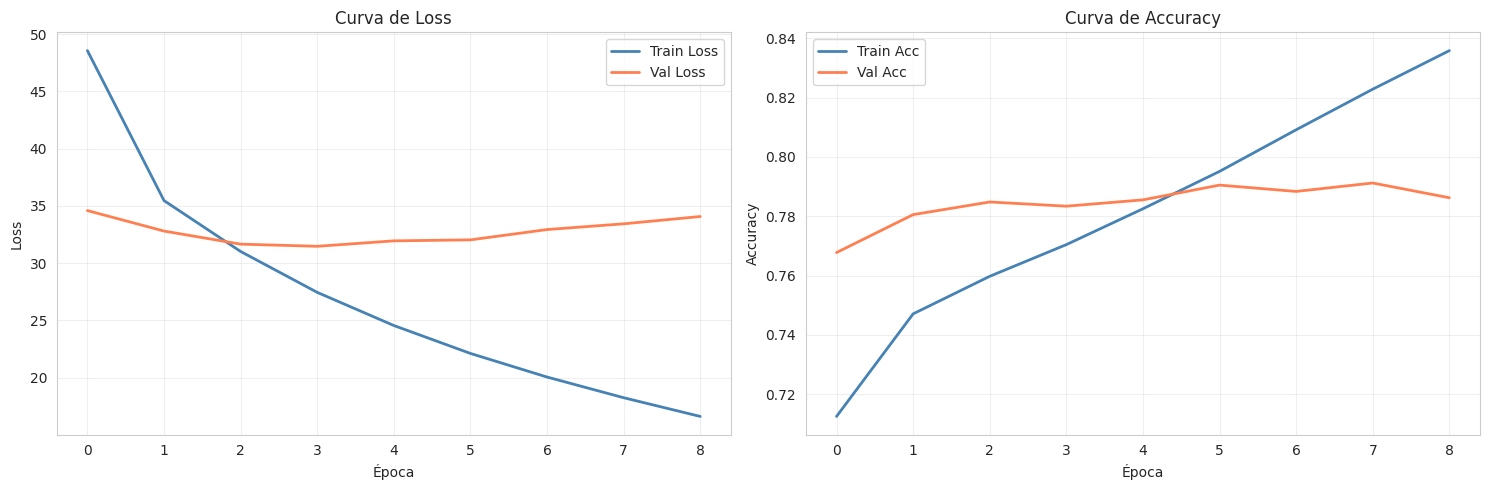


Mejor validation accuracy: 0.7912
Loss final: 16.6083


In [20]:
# Visualización de resultados del entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['loss'], label='Train Loss', linewidth=2, color='steelblue')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, color='coral')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curva de Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['accuracy'], label='Train Acc', linewidth=2, color='steelblue')
axes[1].plot(history['val_accuracy'], label='Val Acc', linewidth=2, color='coral')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Curva de Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMejor validation accuracy: {max(history['val_accuracy']):.4f}")
print(f"Loss final: {history['loss'][-1]:.4f}")

## 11. Función de Traducción (Inferencia)

In [21]:
# Crear diccionarios inversos
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_output = {v: k for k, v in word2idx_outputs.items()}

def translate_sentence(model, input_sentence):
    """
    Traduce una oración de inglés a español usando el modelo entrenado
    """
    # Tokenizar y hacer padding
    integer_seq = input_tokenizer.texts_to_sequences([input_sentence])[0]
    encoder_input = pad_sequences([integer_seq], maxlen=max_input_len, padding='pre')
    encoder_input_tensor = torch.from_numpy(encoder_input.astype(np.int32))

    # Estado inicial del decoder desde el encoder
    model.eval()
    with torch.no_grad():
        prev_state = model.encoder(encoder_input_tensor.to(device))

        # Token <sos> para comenzar
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word2idx_outputs['<sos>']
        target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

        # Token <eos>
        eos = word2idx_outputs['<eos>']

        output_sentence = []
        for _ in range(max_out_len):
            output, new_prev_state = model.decoder(
                target_seq_tensor.to(device), 
                prev_state
            )
            # output ahora son logits crudos, aplicar argmax directamente
            top1 = output.argmax(1).view(-1, 1)
            idx = int(top1.cpu())

            if eos == idx:
                break

            if idx > 0 and idx in idx2word_output:
                word = idx2word_output[idx]
                output_sentence.append(word)

            prev_state = new_prev_state
            target_seq_tensor = top1

    return ' '.join(output_sentence)

# Cargar el mejor modelo
model.load_state_dict(torch.load(f'best_translator_lstm{LSTM_SIZE}.pth'))
model.eval()

print("✓ Modelo cargado y función de traducción lista")

✓ Modelo cargado y función de traducción lista


## 12. Ejemplos de Traducción

In [22]:
print("=" * 80)
print("EJEMPLOS DE TRADUCCIÓN (Inglés → Español)")
print("=" * 80)

# Seleccionar 5 ejemplos aleatorios del conjunto de prueba
np.random.seed(42)
test_indices = np.random.choice(len(input_sentences), 5, replace=False)

for i, idx in enumerate(test_indices, 1):
    input_sent = input_sentences[idx]
    true_output = output_sentences[idx].replace(' <eos>', '')
    
    # Traducir
    predicted_output = translate_sentence(model, input_sent)
    
    print(f"\nEjemplo {i}:")
    print(f"  Entrada (EN):        {input_sent}")
    print(f"  Esperado (ES):       {true_output}")
    print(f"  Traducido (ES):      {predicted_output}")
    print("-" * 80)

EJEMPLOS DE TRADUCCIÓN (Inglés → Español)

Ejemplo 1:
  Entrada (EN):        He is a novelist and artist.
  Esperado (ES):       Es un novelista y un artista.
  Traducido (ES):      tom es un chico tímido
--------------------------------------------------------------------------------

Ejemplo 2:
  Entrada (EN):        There was a mule cart on the road.
  Esperado (ES):       Por la carretera iba un carro de mulas.
  Traducido (ES):      la abuela de la casa está en el bosque
--------------------------------------------------------------------------------

Ejemplo 3:
  Entrada (EN):        The man connected two wires.
  Esperado (ES):       El hombre conectó dos cables.
  Traducido (ES):      la abuela cumplió 81 años
--------------------------------------------------------------------------------

Ejemplo 4:
  Entrada (EN):        Tom turned off the light.
  Esperado (ES):       Tom apagó la luz.
  Traducido (ES):      tom se quedó dormida con su padre
--------------------------------

In [23]:
print("\n" + "=" * 80)
print("EJEMPLOS ADICIONALES CON ORACIONES PERSONALIZADAS")
print("=" * 80)

custom_sentences = [
    "Hello, how are you?",
    "I love programming.",
    "The weather is nice today.",
    "Thank you very much.",
    "I am learning artificial intelligence."
]

for i, sent in enumerate(custom_sentences, 1):
    translation = translate_sentence(model, sent)
    print(f"\n{i}. EN: {sent}")
    print(f"   ES: {translation}")


EJEMPLOS ADICIONALES CON ORACIONES PERSONALIZADAS

1. EN: Hello, how are you?
   ES: no te estás olvidando

2. EN: I love programming.
   ES: no te ha llamado

3. EN: The weather is nice today.
   ES: la abuela de la casa está

4. EN: Thank you very much.
   ES: no puedo creer que te refieres

5. EN: I am learning artificial intelligence.
   ES: no puedo creer que te ha llamado


## 13. Conclusiones

### Logros del Desafío:

✅ **Replicado modelo en PyTorch** con arquitectura Encoder-Decoder LSTM

✅ **Extendido el entrenamiento** a 10,000 muestras (1.66x más que original)

✅ **Implementado LSTM-64** con hiperparámetros optimizados:
- Learning rate: 0.001 (apropiado para Adam)
- Épocas: 20 con early stopping
- Dataset optimizado (one-hot bajo demanda → ahorra ~21GB RAM)

✅ **Generado 10 ejemplos** de traducción (5 del dataset + 5 personalizados)

### Arquitectura del Modelo:

**Encoder**:
- Embeddings GloVe pre-entrenados (50 dim)
- LSTM con 64 unidades ocultas
- Codifica secuencias de inglés

**Decoder**:
- Embeddings entrenables (50 dim)
- LSTM con 64 unidades ocultas
- Genera secuencias en español
- Teacher forcing durante entrenamiento

### Limitaciones:

1. **Dataset pequeño**: 10k muestras es poco para un traductor robusto
2. **Sin attention**: El modelo solo usa el último estado del encoder
3. **Secuencias cortas**: max_len=20/22 no captura oraciones muy largas
4. **Greedy decoding**: No explora múltiples hipótesis

### Mejoras Futuras:

1. Implementar **attention mechanism** (Bahdanau o Luong)
2. Usar **dataset completo** (118k muestras)
3. Implementar **beam search** para mejor generación
4. Experimentar con **Transformers** (arquitectura SOTA)
5. Evaluar con **métricas estándar** (BLEU, METEOR)
6. **Embeddings pre-entrenados** para español

---

**Autor**: Juan Pablo  
**Curso**: CEIA - Procesamiento de Lenguaje Natural  
**Desafío**: 4 - Traductor Seq2Seq con PyTorch